In [1]:
import os
import numpy as np
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/Cardinallop/ML-project-2/master/"
HEART_PATH = os.path.join("datasets", "HEART")
HEART_URL = DOWNLOAD_ROOT + "heart.csv"


#this code below automatically downloads the publicly available data from my github


def fetch_data(heart_url=HEART_URL, heart_path=HEART_PATH):
    if not os.path.isdir(heart_path):
        os.makedirs(heart_path)
    tgz_path = os.path.join(heart_path, "heart.csv")
    urllib.request.urlretrieve(heart_url, tgz_path)


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.tree import export_graphviz
import sklearn.metrics as met
from sklearn.metrics import confusion_matrix
%matplotlib inline
plt.show()

In this project I will try to find a proper model to predict the probability of a heart disease given input factors and I will try to reach the model's maximum predicting capacity by fine-tuning it with a portion of a data. The dataset is available at: https://archive.ics.uci.edu/ml/datasets/Heart+Disease¶

In [2]:
fetch_data()

In [3]:
import pandas as pd

def load_data(heart_path=HEART_PATH):
    csv_path = os.path.join(heart_path, "heart.csv")
    return pd.read_csv(csv_path)

In [4]:
data = load_data()
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


As you can see, some factors are categorical and some are linear.

Before I go any further I will define the input values and describe what they are:

1- age is just an age of a patient

2- sex is a gender, and I have to turn it into Ordinally encoded values, such as 1 for maale and 0 for female

3- cp is a chest-pain. Its encoded as 4 types of it: 1-typical angina, 2- nontypical angina, 3- nonanginal pain, 4- asymptotic. Here I have to encode them into OneHot encoded values

4- trestbps is a resting blood pressure

5- chol is a level of cholesterol

6- fbs is a fasting blood sugar, that is 1 if its higher than 120 or 0 otherwise. Again we have to change its code.

7- restecg is a resting electrocardiographic results encoded as 0-normal, 1-having abnormality, 2-having a hypertrophy

8- thalach is a maximum heart rate achieved

9- exang is a exercise induced angina (1 = yes; 0 = no). This also needs to be encoded as ordinal encoder

10- oldpeak is a ST depression induced by exercise relative to rest

11- slope is a the slope of the peak exercise ST segment

12- ca is a number of major vessels (0-3) colored by flourosopy

13- thal is a heart defect 3 = normal; 6 = fixed defect; 7 = reversable defect

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


### Notice that this is a clean, perfect data without any missing values

In [6]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


you can see from the above graph that a cholesterol has a big effect on heart disease with a mean of 246, much bigger number compared to other values.

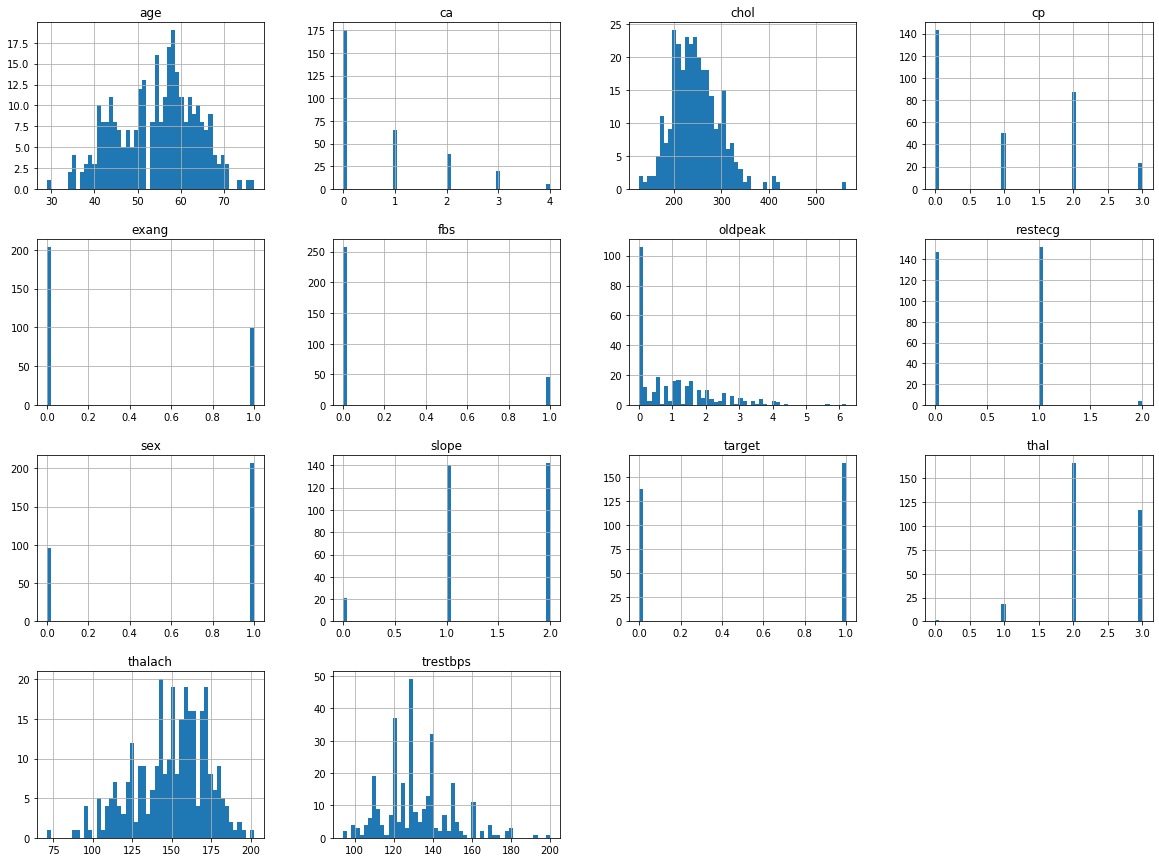

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt 
data.hist(bins=50, figsize=(20,15))
plt.show()

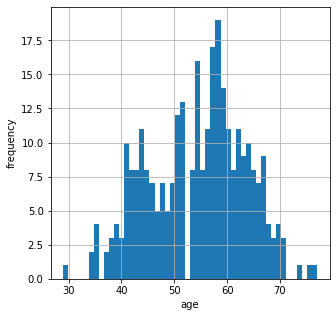

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt 
data['age'].hist(bins=50, figsize=(5,5))
plt.xlabel('age') 
plt.ylabel('frequency')    
plt.show()

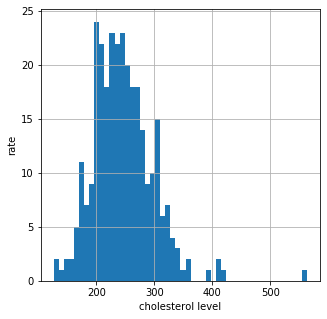

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt 
data['chol'].hist(bins=50, figsize=(5,5))
plt.xlabel('cholesterol level') 
plt.ylabel('rate') 
plt.show()

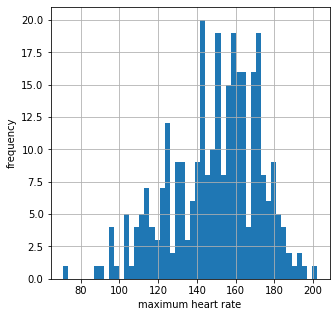

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt 
data['thalach'].hist(bins=50, figsize=(5,5))
plt.xlabel('maximum heart rate') 
plt.ylabel('frequency') 
plt.show()

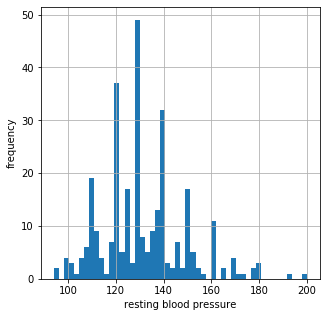

In [124]:
%matplotlib inline
import matplotlib.pyplot as plt 
data['trestbps'].hist(bins=50, figsize=(5,5))
plt.xlabel('resting blood pressure') 
plt.ylabel('frequency') 
plt.show()

### To make analysis on outliers (reminder)

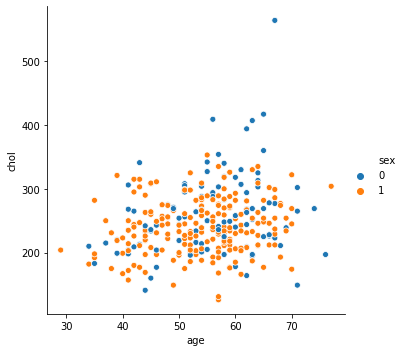

In [125]:
sns.relplot(x='age', y='chol', hue='sex', data=data)
plt.show()

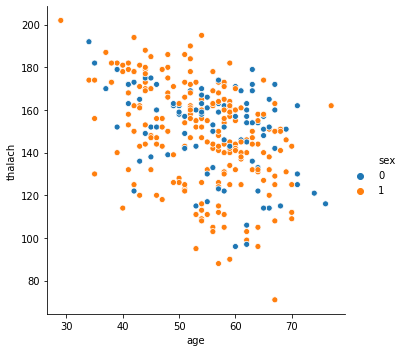

In [26]:
sns.relplot(x='age', y='thalach', hue='sex', data=data)
plt.show()

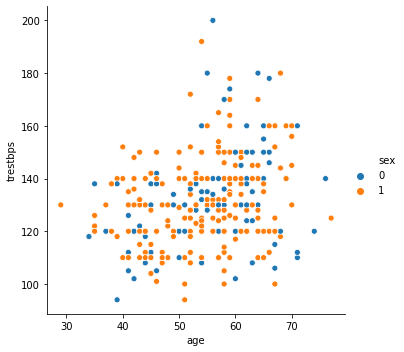

In [27]:
sns.relplot(x='age', y='trestbps', hue='sex', data=data)
plt.show()

In [28]:
lm = smf.ols('target ~ age + chol + sex + cp + trestbps + fbs + restecg + thalach + exang + oldpeak + slope + ca + thal', data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     23.85
Date:                Thu, 12 Dec 2019   Prob (F-statistic):           1.49e-38
Time:                        22:22:09   Log-Likelihood:                -108.28
No. Observations:                 303   AIC:                             244.6
Df Residuals:                     289   BIC:                             296.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8289      0.293      2.830      0.005       0.252       1.405
age           -0.0008      0.003     -0.304      0.761      -0.006       0.004
chol          -0.0004      0.000     -0.838      0.403      -0.001       0.000
sex           -0.1960      0.047     -4.157      0.000      -0.289      -0.103
cp             0.1127      0.022      5.036      0.000       0.069       0.157
trestbps      -0.0020      0.001     -1.583      0.114      -0.004       0.000
fbs            0.0174      0.060      0.291      0.771      -0.100       0.135
restecg        0.0498      0.040      1.249      0.213      -0.029       0.128
thalach        0.0030      0.001      2.671      0.008       0.001       0.005
exang         -0.1440      0.051     -2.804      0.005      -0.245      -0.043
oldpeak       -0.0588      0.023     -2.564      0.011      -0.104      -0.014
slope          0.0790      0.042      1.863      0.063      -0.004       0.162
ca            -0.1006      0.022     -4.603      0.000      -0.144      -0.058
thal          -0.1190      0.036     -3.339      0.001      -0.189      -0.049
==============================================================================
Omnibus:                        6.751   Durbin-Watson:                   1.032
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                6.958
Skew:                          -0.361   Prob(JB):                       0.0308
Kurtosis:                       2.824   Cond. No.                     4.68e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

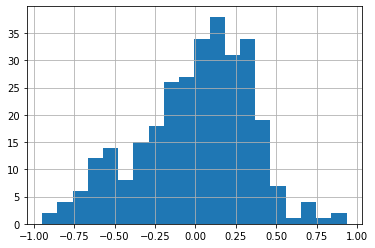

In [29]:
lm.resid.hist(bins=20)
plt.show()

In [30]:
data_new = pd.get_dummies(data, columns=['sex','cp', 'fbs','restecg','exang','slope','ca','thal'], drop_first=True)
data_new.head()

,age,trestbps,chol,thalach,oldpeak,target,sex_1,cp_1,cp_2,cp_3,...,exang_1,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3
0,63,145,233,150,2.3,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,37,130,250,187,3.5,1,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,41,130,204,172,1.4,1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3,56,120,236,178,0.8,1,1,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,57,120,354,163,0.6,1,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0


In [31]:
data_new.columns

Index(['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'target', 'sex_1',
       'cp_1', 'cp_2', 'cp_3', 'fbs_1', 'restecg_1', 'restecg_2', 'exang_1',
       'slope_1', 'slope_2', 'ca_1', 'ca_2', 'ca_3', 'ca_4', 'thal_1',
       'thal_2', 'thal_3'],
      dtype='object')

In [38]:
lm2 = smf.ols('target ~ age+ trestbps + chol + thalach + oldpeak + target + sex_1 + \
           cp_1 + cp_2 + cp_3 + fbs_1 + restecg_1 + restecg_2 + exang_1 + \
               slope_1 + slope_2 + ca_1 + ca_2 + ca_3 + ca_4 + thal_1 + \
                   thal_2 + thal_3', data=data_new).fit()

lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.570e+29
Date:                Thu, 12 Dec 2019   Prob (F-statistic):               0.00
Time:                        22:46:49   Log-Likelihood:                 9712.4
No. Observations:                 303   AIC:                        -1.938e+04
Df Residuals:                     279   BIC:                        -1.929e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.082e-15   3.34e-15      0.324      0.746   -5.49e-15    7.66e-15
age         3.383e-17    2.4e-17      1.412      0.159   -1.33e-17     8.1e-17
trestbps   -7.427e-17   1.11e-17     -6.705      0.000   -9.61e-17   -5.25e-17
chol        -1.03e-17   3.63e-18     -2.834      0.005   -1.75e-17   -3.14e-18
thalach     4.993e-17   1.02e-17      4.917      0.000    2.99e-17    6.99e-17
oldpeak     1.936e-15   2.09e-16      9.257      0.000    1.52e-15    2.35e-15
target         1.0000    5.4e-16   1.85e+15      0.000       1.000       1.000
sex_1       1.055e-15   4.44e-16      2.373      0.018     1.8e-16    1.93e-15
cp_1       -3.955e-16   5.85e-16     -0.676      0.499   -1.55e-15    7.56e-16
cp_2       -3.504e-16   5.01e-16     -0.700      0.485   -1.34e-15    6.35e-16
cp_3       -6.939e-17   7.46e-16     -0.093      0.926   -1.54e-15     1.4e-15
fbs_1       2.567e-16   5.19e-16      0.494      0.622   -7.66e-16    1.28e-15
restecg_1  -6.314e-16    3.7e-16     -1.708      0.089   -1.36e-15    9.61e-17
restecg_2   2.776e-16   1.59e-15      0.175      0.861   -2.85e-15     3.4e-15
exang_1     5.274e-16   4.54e-16      1.161      0.247   -3.67e-16    1.42e-15
slope_1     -1.11e-16   7.77e-16     -0.143      0.886   -1.64e-15    1.42e-15
slope_2    -6.661e-16   8.59e-16     -0.775      0.439   -2.36e-15    1.03e-15
ca_1        1.388e-16   5.01e-16      0.277      0.782   -8.47e-16    1.12e-15
ca_2        6.939e-18   6.43e-16      0.011      0.991   -1.26e-15    1.27e-15
ca_3       -4.163e-17   7.94e-16     -0.052      0.958    -1.6e-15    1.52e-15
ca_4       -3.036e-16   1.41e-15     -0.216      0.829   -3.07e-15    2.46e-15
thal_1     -1.166e-15    2.3e-15     -0.507      0.613   -5.69e-15    3.36e-15
thal_2     -4.441e-16   2.19e-15     -0.203      0.839   -4.75e-15    3.87e-15
thal_3              0    2.2e-15          0      1.000   -4.33e-15    4.33e-15
==============================================================================
Omnibus:                       19.093   Durbin-Watson:                   1.443
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.855
Skew:                          -0.622   Prob(JB):                     2.96e-05
Kurtosis:                       3.326   Cond. No.                     8.43e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.43e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

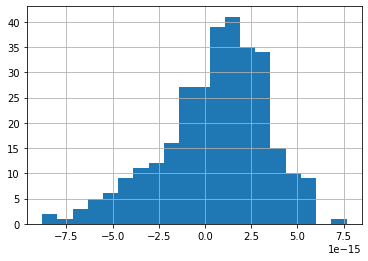

In [39]:
lm2.resid.hist(bins=20)
plt.show()

In [95]:
X = data_new.drop('target', 1)
X.head()

,age,trestbps,chol,thalach,oldpeak,sex_1,cp_1,cp_2,cp_3,fbs_1,...,exang_1,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3
0,63,145,233,150,2.3,1,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
1,37,130,250,187,3.5,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,41,130,204,172,1.4,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,56,120,236,178,0.8,1,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,57,120,354,163,0.6,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0


## Decision Tree regressor:

In [96]:
reg = tree.DecisionTreeRegressor(max_depth = 5)
reg = reg.fit(X, data_new['target'])

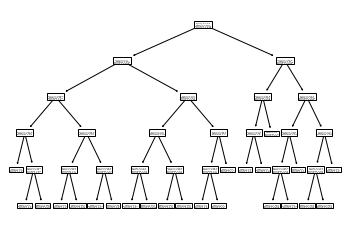

In [97]:
tree.plot_tree(reg)
plt.show()

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, data_new['target'], test_size = 0.2)

In [99]:
reg2 = tree.DecisionTreeRegressor(max_depth = 3)
reg3 = reg2.fit(X_train, y_train)
reg3

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [100]:
predictions = reg3.predict(X_test)
predictions

array([0.95522388, 0.83333333, 0.68292683, 0.08      , 0.95522388,
       0.83333333, 0.08      , 0.08      , 0.95522388, 0.95522388,
       0.08      , 0.21428571, 0.95522388, 0.08      , 0.72222222,
       0.08      , 0.68292683, 0.08      , 0.08      , 0.17647059,
       0.21428571, 0.95522388, 0.95522388, 0.17647059, 0.95522388,
       0.72222222, 0.08      , 0.17647059, 0.68292683, 0.95522388,
       0.21428571, 0.68292683, 0.95522388, 0.72222222, 0.72222222,
       0.68292683, 0.95522388, 0.08      , 0.21428571, 0.08      ,
       0.72222222, 0.17647059, 0.21428571, 0.68292683, 0.95522388,
       0.68292683, 0.95522388, 0.95522388, 0.83333333, 0.95522388,
       0.68292683, 0.95522388, 0.95522388, 0.72222222, 0.08      ,
       0.21428571, 0.72222222, 0.95522388, 0.21428571, 0.95522388,
       0.83333333])

In [101]:
((predictions - y_test)**2).mean()


0.20439636585221957

In [102]:
(data['chol']==0).sum()

0

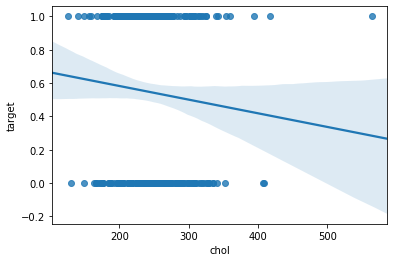

In [104]:
sns.regplot(y='target', x='chol', data = data, fit_reg = True)
plt.show()

In [106]:
logit_model = smf.logit('target ~ chol', data = data).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.685527
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                  303
Model:                          Logit   Df Residuals:                      301
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Dec 2019   Pseudo R-squ.:                0.005288
Time:                        23:38:13   Log-Likelihood:                -207.71
converged:                       True   LL-Null:                       -208.82
Covariance Type:            nonrobust   LLR p-value:                    0.1373
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0016      0.571      1.753      0.080      -0.118       2.122
chol          -0.0033      0.002     -1.471      0.141      -0.008       0.001
==============================================================================
"""

In [107]:
logit_model.params

Intercept    1.001617
chol        -0.003338
dtype: float64

In [108]:
X = np.linspace(0, 600, 320)

In [115]:
p = logit_model.params
reg44 = p['Intercept'] + X*p['chol']

In [116]:
y = np.exp(reg44)/(1 + np.exp(reg44))

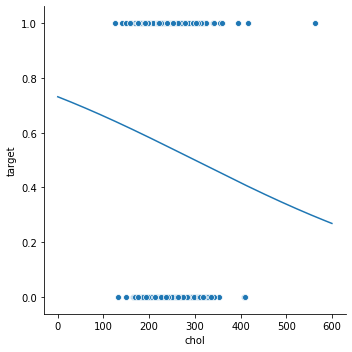

In [122]:
sns.relplot(x='chol', y='target', data=data)
plt.plot(X,y)
plt.show()

In [123]:
logit_model.pred_table()

array([[ 20., 118.],
       [ 23., 142.]])

### In order to work further, I have to split our data and compose and automatic transformer, so whenever I get a new data, I filter the new data with this transformer instead of sorting it all over again¶

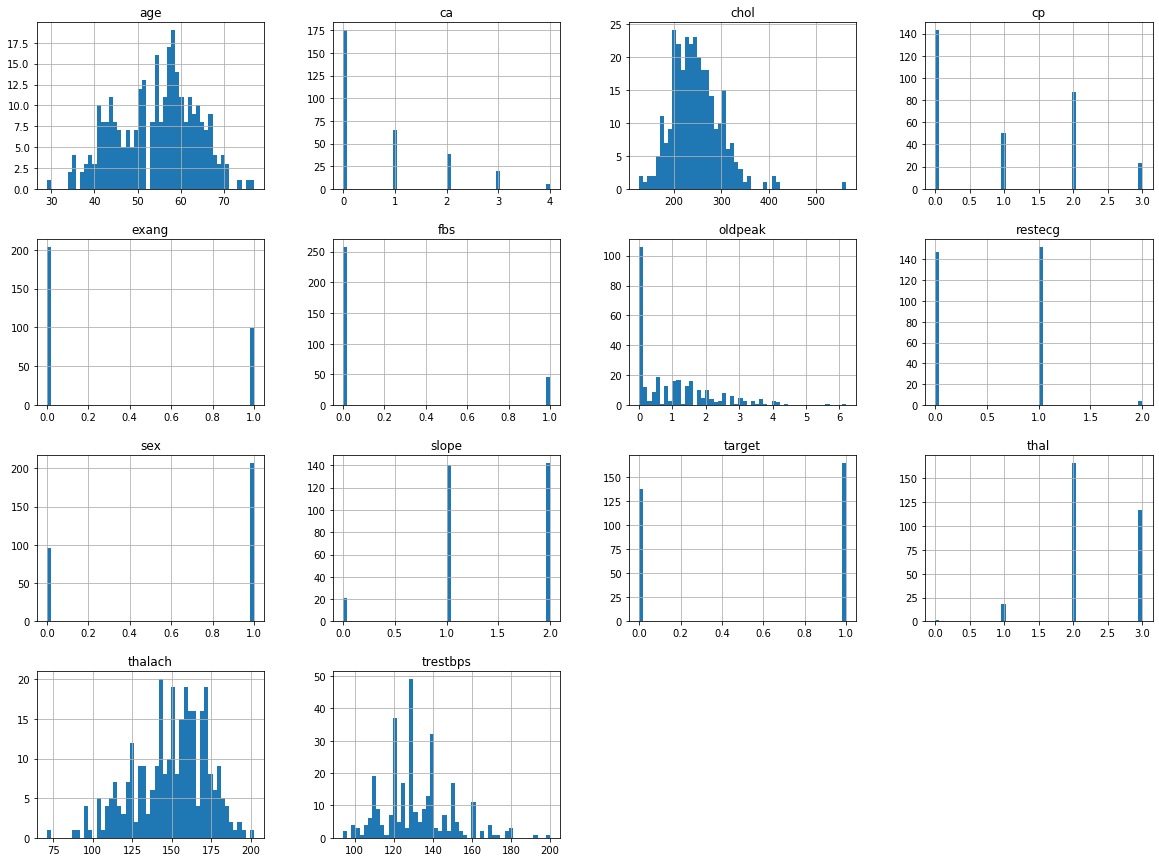

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt 
data.hist(bins=50, figsize=(20,15))
plt.show()

In [43]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

In [44]:
len(train_set)

242

In [45]:
len(test_set)

61

In [46]:
corr_matrix = train_set.corr()

In [47]:
corr_matrix["target"].sort_values(ascending=False)

target      1.000000
cp          0.407768
thalach     0.393415
slope       0.341576
restecg     0.084031
fbs        -0.000924
chol       -0.057714
trestbps   -0.104257
age        -0.233782
sex        -0.304156
thal       -0.338054
ca         -0.375391
exang      -0.443217
oldpeak    -0.447305
Name: target, dtype: float64

#### Correlation Matrix shows how the target value is related to other factors, meaning which factors affects to heart disease by what amoun or what percentage

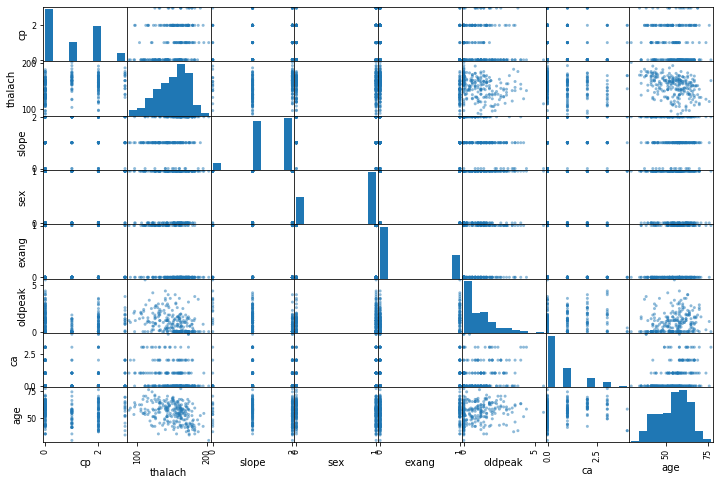

In [48]:
from pandas.plotting import scatter_matrix

attributes = ["cp", "thalach", "slope", "sex", "exang", "oldpeak", "ca", "age"]
scatter_matrix(train_set[attributes], figsize=(12, 8))
plt.show()

#### In order to work further, I have to split our data and compose and automatic transformer, so whenever I get a new data, I filter the new data with this transformer instead of sorting it all over again

In [49]:
dataTrain = train_set.drop("target", axis=1)
dataLabels = train_set["target"].copy()


In [50]:
dataTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242 entries, 132 to 102
Data columns (total 13 columns):
age         242 non-null int64
sex         242 non-null int64
cp          242 non-null int64
trestbps    242 non-null int64
chol        242 non-null int64
fbs         242 non-null int64
restecg     242 non-null int64
thalach     242 non-null int64
exang       242 non-null int64
oldpeak     242 non-null float64
slope       242 non-null int64
ca          242 non-null int64
thal        242 non-null int64
dtypes: float64(1), int64(12)
memory usage: 26.5 KB


In [51]:
dataTrain_num = dataTrain.drop("sex", axis=1)
dataTrain_num = dataTrain_num.drop("cp", axis=1)
dataTrain_num = dataTrain_num.drop("fbs", axis=1)
dataTrain_num = dataTrain_num.drop("restecg", axis=1)
dataTrain_num = dataTrain_num.drop("exang", axis=1)
dataTrain_num = dataTrain_num.drop("slope", axis=1)
dataTrain_num = dataTrain_num.drop("thal", axis=1)

In [52]:
dataTrain_num.head()

,age,trestbps,chol,thalach,oldpeak,ca
132,42,120,295,162,0.0,0
202,58,150,270,111,0.8,0
196,46,150,231,147,3.6,0
75,55,135,250,161,1.4,0
176,60,117,230,160,1.4,2


In [53]:
dataTrain_num.shape

(242, 6)

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

In [55]:
dataTrain.shape

(242, 13)

In [56]:
from sklearn.compose import ColumnTransformer

num_attribs = list(dataTrain_num)
cat_attribs = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]


full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

train_prepared = full_pipeline.fit_transform(dataTrain)

/Users/boburmurtozaev/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [57]:
train_prepared.shape

(242, 26)

### Now let's compare and contrast 3 different models which seem applicable to the given data in order to predict our information. At the end I will pick the best model to work with the given data

### 1-Model: DecisionTree Classifier¶


In [58]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier()
tree_clf.fit(train_prepared, dataLabels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

### Testing and Validation:

In [59]:
some_dat = dataTrain.iloc[:5]
some_labs = dataLabels.iloc[:5]
some_dat_prepared = full_pipeline.transform(some_dat)
print("Predictions:", tree_clf.predict(some_dat_prepared))
print("Labels:", list(some_labs))

Predictions: [1 0 0 1 0]
Labels: [1, 0, 0, 1, 0]


### Cross Validation Score:

In [60]:
from sklearn.model_selection import cross_val_score
cvsscores = cross_val_score(tree_clf, train_prepared, dataLabels,
                         scoring="accuracy", cv=10)

In [61]:
>>> def display_scores(scores):
...     print("Scores:", scores)
...     print("Mean:", scores.mean())
...     print("Standard deviation:", scores.std())
...
>>> display_scores(cvsscores)

Scores: [0.76       0.76       0.68       0.66666667 0.79166667 0.70833333
 0.70833333 0.79166667 0.75       0.7826087 ]
Mean: 0.7399275362318841
Standard deviation: 0.04363217924585581


### Confusion Matrix:¶

In [62]:
from sklearn.model_selection import cross_val_predict

train_predo = cross_val_predict(tree_clf, train_prepared, dataLabels, cv=10)

In [63]:
>>> from sklearn.metrics import confusion_matrix
>>> confusion_matrix(dataLabels, train_predo)

array([[79, 30],
       [38, 95]])

### Precision and Recall:

In [64]:
>>> from sklearn.metrics import precision_score, recall_score
>>> precision_score(dataLabels, train_predo)

0.76

In [65]:
>>> recall_score(dataLabels, train_predo)

0.7142857142857143

### F-score:

In [66]:
>>> from sklearn.metrics import f1_score
>>> f1_score(dataLabels, train_predo)

0.7364341085271319

### ROC Curve:

In [67]:
y_scores = cross_val_predict(tree_clf, train_prepared, dataLabels, cv=3)

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(dataLabels, y_scores)

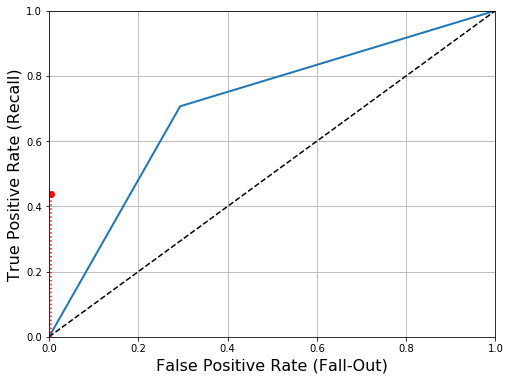

In [68]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])                                   
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                         
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") 
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  
plt.plot([4.837e-3], [0.4368], "ro")               
                      
plt.show()

In [69]:
from sklearn.metrics import roc_auc_score

roc_auc_score(dataLabels, y_scores)

0.7065944678209284

## 2-Model: RandomForestClassifier:

In [70]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(train_prepared, dataLabels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

### Test and Validation: 

In [71]:
some_datq = dataTrain.iloc[:5]
some_labsq = dataLabels.iloc[:5]
some_dat_preparedq = full_pipeline.transform(some_datq)
print("Predictions:", forest_clf.predict(some_dat_preparedq))

print("Labels:", list(some_labsq))

Predictions: [1 0 0 1 0]
Labels: [1, 0, 0, 1, 0]


### Cross Validation Score: 

In [72]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, train_prepared, dataLabels,
                                scoring="accuracy", cv=10)

display_scores(forest_scores)

Scores: [0.76       0.88       0.88       0.79166667 0.875      0.70833333
 0.75       0.875      0.75       0.82608696]
Mean: 0.8096086956521737
Standard deviation: 0.06235341305929312


### Confusion Matrix: 

In [73]:
train_predo1 = cross_val_predict(forest_clf, train_prepared, dataLabels, cv=10)

In [74]:
>>> from sklearn.metrics import confusion_matrix
>>> confusion_matrix(dataLabels, train_predo1)

array([[ 86,  23],
       [ 23, 110]])

### Precision and Recall: 

In [75]:
>>> from sklearn.metrics import precision_score, recall_score
>>> precision_score(dataLabels, train_predo1)

0.8270676691729323

### ROC Curve:

In [76]:
y_scores1 = cross_val_predict(forest_clf, train_prepared, dataLabels, cv=3)

fpr1, tpr1, thresholds1 = roc_curve(dataLabels, y_scores1)

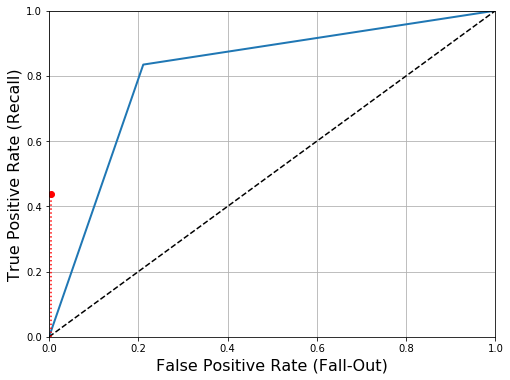

In [77]:
plt.figure(figsize=(8, 6))                         
plot_roc_curve(fpr1, tpr1)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") 
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  
plt.plot([4.837e-3], [0.4368], "ro")               
                      
plt.show()

In [78]:
roc_auc_score(dataLabels, y_scores1)

0.8117886459267434

## 3-Model: KNeighbors Classifier:

In [79]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)

neigh.fit(train_prepared, dataLabels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

### Test and Validation:

In [80]:
some_dat6 = dataTrain.iloc[:10]
some_labs6 = dataLabels.iloc[:10]
some_dat_prepared6 = full_pipeline.transform(some_dat6)
print("Predictions:", neigh.predict(some_dat_prepared6))

print("Labels:", list(some_labs6))


Predictions: [1 0 1 1 0 1 1 1 1 1]
Labels: [1, 0, 0, 1, 0, 1, 1, 1, 0, 1]


### Cross Validation Score:

In [81]:
KN_scores = cross_val_score(neigh, train_prepared, dataLabels,
                                scoring="accuracy", cv=10)

display_scores(KN_scores)

Scores: [0.68       0.8        0.84       0.83333333 0.83333333 0.79166667
 0.70833333 0.91666667 0.75       0.86956522]
Mean: 0.8022898550724638
Standard deviation: 0.06898727466984479


### Confusion Matrix: 

In [82]:
train_predo2 = cross_val_predict(neigh, train_prepared, dataLabels, cv=10)

In [83]:
>>> from sklearn.metrics import confusion_matrix
>>> confusion_matrix(dataLabels, train_predo2)

array([[ 82,  27],
       [ 21, 112]])

### Precision Score: 

In [84]:
>>> from sklearn.metrics import precision_score, recall_score
>>> precision_score(dataLabels, train_predo2)

0.8057553956834532

## Here I stop, because if you compare the above 3 models, among them, the best model is Random Forest Classifier with over 80% precision and I don't think I can get any better result from other models. However I may get much improved results if I apply Neural Networks, unfortunately, I yet have to practice how to work with Neural Networks. I hope that I will have the time and opportunity to use Neural Networks. As for this results, we can use Random Forest Classifier (note: not a regressor) to predict how highly a person can get a heart disease. But before we apply RFC to our test data, let's tune our model with more better parameters

## Fine_Tuning the Model:

In [85]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]},
    {'bootstrap': [False],'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]},
  ]

forest_clf = RandomForestClassifier()

grid_search = GridSearchCV(forest_clf, param_grid, cv=5,
                           scoring='accuracy',
                           return_train_score=True)

grid_search.fit(train_prepared, dataLabels)

/Users/boburmurtozaev/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=Fa...
                          'min_samples_leaf': [1, 5, 8],
                          'min_samples_split': [2, 3, 5],
                          'n_estimators': [

In [86]:
>>> grid_search.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 4}

In [87]:
>>> grid_search.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=5, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=4,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [88]:
>>> cvres = grid_search.cv_results_

In [89]:
>>> feature_importances = grid_search.best_estimator_.feature_importances_
>>> feature_importances

array([5.22223519e-02, 4.42641984e-02, 8.57082334e-03, 2.51872562e-02,
       1.51742123e-01, 1.14704864e-01, 4.00669502e-03, 3.58721671e-03,
       8.36204864e-02, 4.90415297e-05, 2.41186445e-03, 3.40909659e-04,
       5.24915907e-05, 0.00000000e+00, 1.30650897e-04, 1.07540402e-02,
       0.00000000e+00, 7.67968266e-02, 5.56461458e-02, 0.00000000e+00,
       5.48338063e-03, 1.36711131e-01, 0.00000000e+00, 0.00000000e+00,
       1.55432914e-01, 6.82845891e-02])

In [90]:
>>> cat_encoder = full_pipeline.named_transformers_["cat"]
>>> cat_ordinal_attribs = list(cat_encoder.categories_[0])
>>> attributes = num_attribs + cat_ordinal_attribs
>>> sorted(zip(feature_importances, attributes), reverse=True)

[(0.15174212254409167, 'oldpeak'),
 (0.11470486416845276, 'ca'),
 (0.052222351894044464, 'age'),
 (0.044264198360495305, 'trestbps'),
 (0.025187256214403927, 'thalach'),
 (0.008570823337715895, 'chol'),
 (0.004006695017687863, 0.0),
 (0.003587216705811865, 1.0)]

In [91]:
final_model = grid_search.best_estimator_

In [92]:
from sklearn.metrics import make_scorer, accuracy_score

data_train2 = load_data()

X_all = data_train2.drop(['target'], axis=1)
y_all = data_train2['target']

X_all_transformed = full_pipeline.transform(X_all)

num_test = 0.20

X_train, X_test, y_train, y_test = train_test_split(X_all_transformed, y_all, test_size=num_test, random_state=23)

final_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=5, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=4,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [93]:
predictions = final_model.predict(X_test)
print(accuracy_score(y_test, predictions))

0.8032786885245902


### As you can see above model reached 80% precision compared to the previous 80% of RandomForestClassifier and compared to 70% of DecisionTree Classifier with much more fine-tuned parameters